# Punto 3 – Modelado de Serie Diaria (Uso del Dinero)
**Modelo elegido:** SARIMA (statsmodels) con estacionalidad semanal `S=7`.

**Objetivo:** Entrenar con **jul–sep 2022**, validar en **oct 2022** (MAPE) y pronosticar **nov 2022**.

## 1. Imports y configuración de paths

Importa librerías necesarias (numpy, pandas, matplotlib, statsmodels, warnings) y configura rutas robustas para cargar los datos y guardar resultados.

In [5]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Detección robusta del ROOT del proyecto (soporta ejecutar desde modelos/ o raíz)
CANDIDATES = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
ROOT = None

RAW_CLEAN = "../data/clean/Punto3.SerieUsodeldinero_clean.csv"
OUT_DIR = "../modelos/outputs_p3/"

RAW_CLEAN

'../data/clean/Punto3.SerieUsodeldinero_clean.csv'

## 2. Carga y preparación de datos

Cargamos el archivo CSV limpio, convierte la columna de fechas, ordena y define la variable objetivo. Realiza el split en train (jul-sep 2022) y test (oct 2022).

In [7]:
# %% Cargar datos limpios
df = pd.read_csv(RAW_CLEAN, parse_dates=["fecha"])
df = df.sort_values("fecha").reset_index(drop=True)

# Serie principal (en millones)
y_col = "valor_total_millones"
df = df.set_index("fecha")

# Split
train = df.loc["2022-07-01":"2022-09-30", [y_col]].copy()
test_oct = df.loc["2022-10-01":"2022-10-31", [y_col]].copy()

train.shape, test_oct.shape, train.head(3), test_oct.head(3)

((92, 1),
 (31, 1),
             valor_total_millones
 fecha                           
 2022-07-01          55871.592578
 2022-07-02          10567.733300
 2022-07-03            104.749304,
             valor_total_millones
 fecha                           
 2022-10-01          12811.874289
 2022-10-02              0.000000
 2022-10-03          41584.688258)

## 3. Visualización de la serie diaria

Grafica la serie completa de julio a octubre 2022 para inspección visual de tendencias y estacionalidad. (Revisamos lo mismo que el EDA)

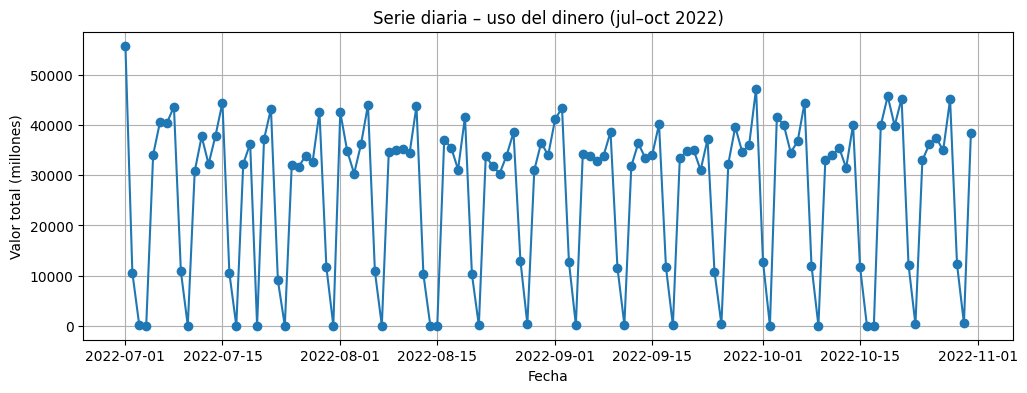

In [8]:
# %% Visual: serie completa (julio - octubre)
plt.figure(figsize=(12,4))
plt.plot(df.index, df[y_col], marker='o', linestyle='-')
plt.title("Serie diaria – uso del dinero (jul–oct 2022)")
plt.xlabel("Fecha")
plt.ylabel("Valor total (millones)")
plt.grid(True)
plt.show()

## 4. Grid search de hiperparámetros SARIMA

Realiza una búsqueda pequeña sobre los hiperparámetros (p,d,q,P,D,Q) de SARIMA con estacionalidad semanal S=7, seleccionando el modelo con menor AIC.

### Búsqueda (pequeña) de hiperparámetros SARIMA usando AIC

In [9]:
# %% Grid search básico de SARIMA con S=7
import math

best = {"aic": math.inf, "order": None, "seasonal_order": None, "res": None}

y_train = train[y_col]

for p in range(0,3):       # 0..2
    for d in range(0,2):   # 0..1
        for q in range(0,3):  # 0..2
            for P in range(0,2):  # 0..1
                for D in range(0,2):  # 0..1
                    for Q in range(0,2):  # 0..1
                        try:
                            model = SARIMAX(
                                y_train,
                                order=(p,d,q),
                                seasonal_order=(P,D,Q,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            res = model.fit(disp=False)
                            aic = res.aic
                            if aic < best["aic"]:
                                best.update({"aic": aic, "order": (p,d,q), "seasonal_order": (P,D,Q,7), "res": res})
                        except Exception:
                            continue

best

{'aic': np.float64(1540.6670583001874),
 'order': (1, 1, 2),
 'seasonal_order': (0, 1, 1, 7),
 'res': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f001510faf0>}

## 5. Ajuste del mejor modelo y predicción en octubre

Ajusta el modelo SARIMA óptimo sobre el set de entrenamiento y genera el pronóstico para octubre 2022. Calcula el MAPE sobre el periodo de validación.

In [10]:
# %% Ajuste final con la mejor configuración en TRAIN y predicción en OCT
res = best["res"]
order, seasonal_order = best["order"], best["seasonal_order"]

# Pronóstico out-of-sample para octubre
steps = len(test_oct)
fc_oct = res.get_forecast(steps=steps)
pred_oct = fc_oct.predicted_mean
ci_oct = fc_oct.conf_int(alpha=0.05)  # 95%
ci_oct.columns = ["lower", "upper"]
pred_oct.index = test_oct.index  # alinear a fechas reales de octubre
ci_oct.index = test_oct.index

# Métrica MAPE (evitando división por cero)
y_true = test_oct[y_col].astype(float)
y_pred = pred_oct.astype(float)
eps = 1e-8
mape_oct = (np.abs(y_true - y_pred) / np.maximum(eps, np.abs(y_true))).mean() * 100

print("Mejor orden:", order, "Mejor orden estacional:", seasonal_order)
print(f"MAPE en octubre: {mape_oct:.3f}%")

Mejor orden: (1, 1, 2) Mejor orden estacional: (0, 1, 1, 7)
MAPE en octubre: 12272917479764.928%


## 6. Gráfico: comparación real vs predicción octubre

Grafica los valores reales y predichos para octubre, incluyendo intervalos de confianza del 95%.

In [ ]:
# %% Gráfico: Oct real vs predicción + IC
plt.figure(figsize=(12,4))
plt.plot(y_true.index, y_true.values, marker='o', linestyle='-', label='Real (Oct)')
plt.plot(pred_oct.index, y_pred.values, marker='o', linestyle='--', label='Pred (Oct)')
plt.fill_between(ci_oct.index, ci_oct['lower'], ci_oct['upper'], alpha=0.2, label='IC 95%')
plt.title(f"Octubre 2022 – Real vs Predicción SARIMA | MAPE={mape_oct:.2f}%")
plt.xlabel("Fecha"); plt.ylabel("Valor (millones)"); plt.grid(True); plt.legend()
plt.show()

## 7. Pronóstico para noviembre 2022

Genera el pronóstico para noviembre 2022 (30 días) usando el modelo entrenado, y prepara el DataFrame con los resultados y sus intervalos de confianza.

In [ ]:
# %% Pronóstico Noviembre 2022 (30 días)
# Reentrenar con train completo (jul–oct) puede ser discutible; seguimos con train (jul–sep) para mantener protocolo estricto.
# Sin embargo, muchas veces el pronóstico futuro se hace con todo lo disponible hasta el presente. Dejamos ambas opciones.

# Opción A (estricta al protocolo): usar el mismo modelo entrenado con jul–sep
steps_nov = 30  # 2022-11 tiene 30 días
fc_nov = res.get_forecast(steps=steps_nov)
pred_nov = fc_nov.predicted_mean
ci_nov = fc_nov.conf_int(alpha=0.05)
ci_nov.columns = ["lower", "upper"]

# Generar índice de fechas para noviembre 2022
nov_index = pd.date_range("2022-11-01", "2022-11-30", freq="D")
pred_nov.index = nov_index
ci_nov.index = nov_index

forecast_nov = pd.DataFrame({
    "fecha": pred_nov.index,
    "yhat": pred_nov.values,
    "yhat_lower": ci_nov["lower"].values,
    "yhat_upper": ci_nov["upper"].values
})

forecast_nov.head()

## 8. Gráfico: histórico + forecast noviembre

Grafica la serie histórica (jul-oct) junto con el forecast de noviembre y sus intervalos de confianza.

In [ ]:
# %% Gráfico: Historia (jul–oct) + Forecast nov 2022
plt.figure(figsize=(12,4))
plt.plot(df.index, df[y_col], marker='o', linestyle='-', label='Histórico (jul–oct)')
plt.plot(forecast_nov["fecha"], forecast_nov["yhat"], marker='o', linestyle='--', label='Forecast Nov')
plt.fill_between(forecast_nov["fecha"], forecast_nov["yhat_lower"], forecast_nov["yhat_upper"], alpha=0.2, label='IC 95%')
plt.title("Histórico + Pronóstico Nov 2022 (SARIMA S=7)")
plt.xlabel("Fecha"); plt.ylabel("Valor (millones)"); plt.grid(True); plt.legend()
plt.show()

## 9. Guardar resultados y exportables

Guarda métricas, predicciones de octubre, forecast de noviembre y un archivo Excel con todos los resultados en la carpeta outputs_p3.

In [ ]:
# %% Guardar resultados
# 1) Métricas
metrics = pd.DataFrame([{
    "modelo": "SARIMA",
    "order": str(order),
    "seasonal_order": str(seasonal_order),
    "AIC_train": best["aic"],
    "MAPE_oct": mape_oct
}])
metrics_path = OUT_DIR / "metrics_punto3.csv"
metrics.to_csv(metrics_path, index=False)

# 2) Predicciones Oct
pred_oct_df = pd.DataFrame({
    "fecha": y_true.index,
    "real_oct": y_true.values,
    "pred_oct": y_pred.values,
    "lower_95": ci_oct["lower"].values,
    "upper_95": ci_oct["upper"].values
})
pred_oct_path = OUT_DIR / "pred_oct.csv"
pred_oct_df.to_csv(pred_oct_path, index=False)

# 3) Forecast Noviembre
forecast_path = OUT_DIR / "forecast_nov.csv"
forecast_nov.to_csv(forecast_path, index=False)

# 4) Excel entregable
xlsx_path = OUT_DIR / "ENTREGABLE_Punto3.xlsx"
with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
    metrics.to_excel(writer, sheet_name="Resumen", index=False)
    pred_oct_df.to_excel(writer, sheet_name="Pred_Oct", index=False)
    forecast_nov.to_excel(writer, sheet_name="Forecast_Nov", index=False)

print("Guardado:")
print(" -", metrics_path)
print(" -", pred_oct_path)
print(" -", forecast_path)
print(" -", xlsx_path)

### Notas
- El grid de SARIMA es **pequeño** para mantener tiempos bajos. Si el MAPE no satisface, ampliar rangos de `p,d,q,P,D,Q`.
- La métrica se calcula con MAPE "seguro" ante ceros (evita división por cero).
- Los **domingos/festivos** ya venían en 0 desde el EDA de limpieza.
- Para producción, se recomienda reentrenar con **todos los datos disponibles** antes de proyectar meses futuros.